# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import pickle
import ast

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp
import lightgbm as lgb
from skopt import BayesSearchCV

sys.path += ['./ilikeds']
import eda 
import helper_functions as h
import train_classifier as t

import warnings                             
warnings.filterwarnings('ignore')
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

azdias = pd.read_pickle ('../data/azdias.p')    
customers = pd.read_pickle ('../data/customers.p')    

sampling_rate = 0.1
r=np.random.randint(0, azdias.shape[0], int(azdias.shape[0]*sampling_rate))
azdias=azdias.loc[r,:].copy()
r=np.random.randint(0, customers.shape[0], int(customers.shape[0]*sampling_rate))
customers=customers.loc[r,:].copy()

In [3]:
# read in feature info file
feat_info = pd.read_csv('./feats_info.csv', sep=';', names=['feat', 'type', 'unknow'])
feat_info.set_index('feat', inplace =True)
feat_info

,type,unknow
feat,,
AGER_TYP,categorical,"[-1,0]"
ALTERSKATEGORIE_FEIN,ordinal,"[-1,0,9]"
ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]"
ALTER_HH,ordinal,[0]
ANREDE_KZ,binary,"[-1,0]"
...,...,...
RT_UEBERGROESSE,categorical,[]
STRUKTURTYP,categorical,[]
UMFELD_ALT,categorical,[]


In [4]:
# create  a EDA  instance for Azdias.
eda_azdias= eda.EDA(azdias, feat_info, label = 'Azdias')

# create  a EDA  instance for Azdias. for  customers
eda_customers= eda.EDA(customers, feat_info, label = 'Customers')

In [5]:
mixed = eda_azdias.feat_info[ (eda_azdias.feat_info.type == 'mixed') & (eda_azdias.feat_info.is_drop == 0)]
mixed

,type,unknow,is_drop,action,n_nans,percent_of_nans,value_distinct,value_count,value_mean,value_std,value_min,value_max,value_Q1,value_Q3,value_IRQ
feat,,,,,,,,,,,,,,,
CAMEO_INTL_2015,mixed,"['-1','XX']",0,0,9727,0.109,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LP_LEBENSPHASE_FEIN,mixed,[0],0,0,497,0.006,42,88625.0,14.641354,12.597494,0.0,40.0,4.0,27.0,23.0
LP_LEBENSPHASE_GROB,mixed,[0],0,0,497,0.006,14,88625.0,4.458821,3.849711,0.0,12.0,1.0,8.0,7.0
PRAEGENDE_JUGENDJAHRE,mixed,"[-1,0]",0,0,0,0.000,16,89122.0,8.181448,4.837106,0.0,15.0,5.0,14.0,9.0
EINGEFUEGT_AM,mixed,[],0,0,9136,0.103,2692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Preprocessing

In [6]:
####  Define action dictionary 
# action_dic ={
#     1:  'drop: high missing values',
#     2:  'drop: duplicated',
#     3:  're-encoding: mapping',    
#     4:  're-encoding: logarithmic scaling',        
#     5:  'split',
# }

In [7]:
# Removing the three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP') in Customers
feats_customers_excl  = list(set(eda_customers.data.columns) - set(eda_azdias.data.columns))
feats_customers_excl
eda_customers.data.drop(columns = feats_customers_excl, inplace =True)

####  Step 1:  Converting of missing and unknown data to NaN

In [8]:
eda_azdias.missing2nan()
eda_customers.missing2nan()

# Re-Collecting feature stats
eda_azdias.update_stats()
eda_customers.update_stats()

Number of missing values in Azdias:
Before converstion is 3311120
Ater converstion IS 8452003
Increase in missing values: 155.26 % 
Number of missing values in Customers:
Before converstion is 1386307
Ater converstion IS 2428994
Increase in missing values: 75.21 % 


####  Step 2: Remove rows and columns with high miss values

##### a. Deleting rows

Text(0.5, 1.0, 'Distribution of missing value per row')

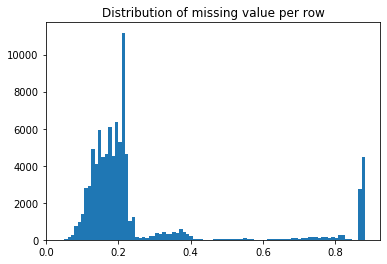

In [9]:
rows_n_nans = azdias.isnull().sum(axis=1)
plt.hist(rows_n_nans / azdias.shape[1], bins=90)
plt.title('Distribution of missing value per row')

In [10]:
_, rows_droped = h.split_dataset(azdias, threshold=0.25)
n_deleted_rows = rows_droped.shape[0]
print(f'Before delete the missing rows, {eda_azdias} has {eda_azdias.data.shape[0]} rows')
azdias.drop(index = rows_droped.index, inplace =True)
print(f'After delete the missing rows, {eda_azdias} has {eda_azdias.data.shape[0]} rows')
print(f'Delete {n_deleted_rows} rows in total')

Before delete the missing rows, Azdias has 89122 rows
After delete the missing rows, Azdias has 73627 rows
Delete 15495 rows in total


In [11]:
_, rows_droped = h.split_dataset(customers, threshold=0.25)
n_deleted_rows = rows_droped.shape[0]
print(f'Before delete the high missing rate rows, {eda_customers} has {eda_customers.data.shape[0]} rows')
eda_customers.data.drop(index = rows_droped.index, inplace =True)
print(f'After delete the hitg missing rate rows, {eda_customers} has {eda_customers.data.shape[0]} rows')
print(f'Delete {n_deleted_rows} rows in total')

Before delete the high missing rate rows, Customers has 19165 rows
After delete the hitg missing rate rows, Customers has 13395 rows
Delete 5770 rows in total


##### b. Deleteing columns

Text(0.5, 1.0, 'Distribution of missing value per column')

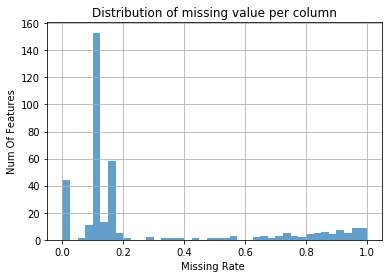

In [12]:
eda_azdias.feat_info.percent_of_nans.sort_values().hist(bins = 40, alpha = 0.7)
plt.xlabel('Missing Rate ')
plt.ylabel('Num Of Features')
plt.title('Distribution of missing value per column')

In [13]:
thr_col_missing = 0.6
feats_high_missing_azdias = eda_azdias.feat_info.loc[eda_azdias.feat_info.percent_of_nans > thr_col_missing].index
feats_high_missing_azdias

Index(['AGER_TYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SOZIALES', 'D19_TECHNIK',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_RES

In [14]:
feats_high_missing_customers = eda_customers.feat_info.loc[eda_customers.feat_info.percent_of_nans >thr_col_missing ].index
feats_high_missing_customers

Index(['D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_TECHNIK', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_MOBILE',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
       'D19_VERSAND_ANZ_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSICHERUN

In [15]:
# # Get features with high missing rates in both datasets
feats_high_missing = set(feats_high_missing_azdias).intersection(set(feats_high_missing_customers))
feats_high_missing

{'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_TECHNIK',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_MOBILE',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSAND_

In [16]:
eda_azdias.feat_info.loc[feats_high_missing,'action'] = h.action_dic[1]
eda_azdias.feat_info.loc[feats_high_missing,'is_drop'] = 1

eda_customers.feat_info.loc[feats_high_missing,'action'] = h.action_dic[1]
eda_customers.feat_info.loc[feats_high_missing,'is_drop'] = 1

In [17]:
eda_azdias.feat_info.loc[feats_high_missing]

,type,unknow,is_drop,action,n_nans,percent_of_nans,value_distinct,value_count,value_mean,value_std,value_min,value_max,value_Q1,value_Q3,value_IRQ
feat,,,,,,,,,,,,,,,
D19_BANKEN_GROSS,ordinal,[0],1,drop: high missing values,78449,0.880,7,10673.0,4.779443,1.600190,1.0,6.0,3.0,6.0,3.0
D19_HANDWERK,ordinal,[0],1,drop: high missing values,76688,0.860,7,12434.0,6.114123,0.648893,2.0,7.0,6.0,6.0,0.0
D19_TELKO_ANZ_24,ordinal,[0],1,drop: high missing values,82541,0.926,7,6581.0,1.360128,0.651920,1.0,6.0,1.0,2.0,1.0
D19_BANKEN_OFFLINE_DATUM,ordinal,[10],1,drop: high missing values,87153,0.978,10,1969.0,6.638903,2.437038,1.0,9.0,5.0,9.0,4.0
D19_BILDUNG,ordinal,[0],1,drop: high missing values,81353,0.913,8,7769.0,5.556571,1.602625,1.0,7.0,6.0,7.0,1.0
D19_NAHRUNGSERGAENZUNG,ordinal,[0],1,drop: high missing values,85226,0.956,8,3896.0,5.583162,1.480646,1.0,7.0,5.0,7.0,2.0
D19_VERSAND_ONLINE_QUOTE_12,ordinal,[0],1,drop: high missing values,67275,0.755,11,21847.0,9.490502,1.508646,1.0,10.0,10.0,10.0,0.0
D19_SAMMELARTIKEL,ordinal,[0],1,drop: high missing values,80147,0.899,8,8975.0,5.942841,0.726284,1.0,7.0,6.0,6.0,0.0
D19_VERSI_ANZ_24,ordinal,[0],1,drop: high missing values,77680,0.872,7,11442.0,1.623055,0.831869,1.0,6.0,1.0,2.0,1.0


In [18]:
eda_azdias.data.drop(columns = list(feats_high_missing), inplace =True)
eda_customers.data.drop(columns = list(feats_high_missing), inplace =True)

# Re-Collecting feature stats
eda_azdias.update_stats()
eda_customers.update_stats()

#### Step 3.  Remove duplicated features

##### a.  Compare _GROB and _FEIN features

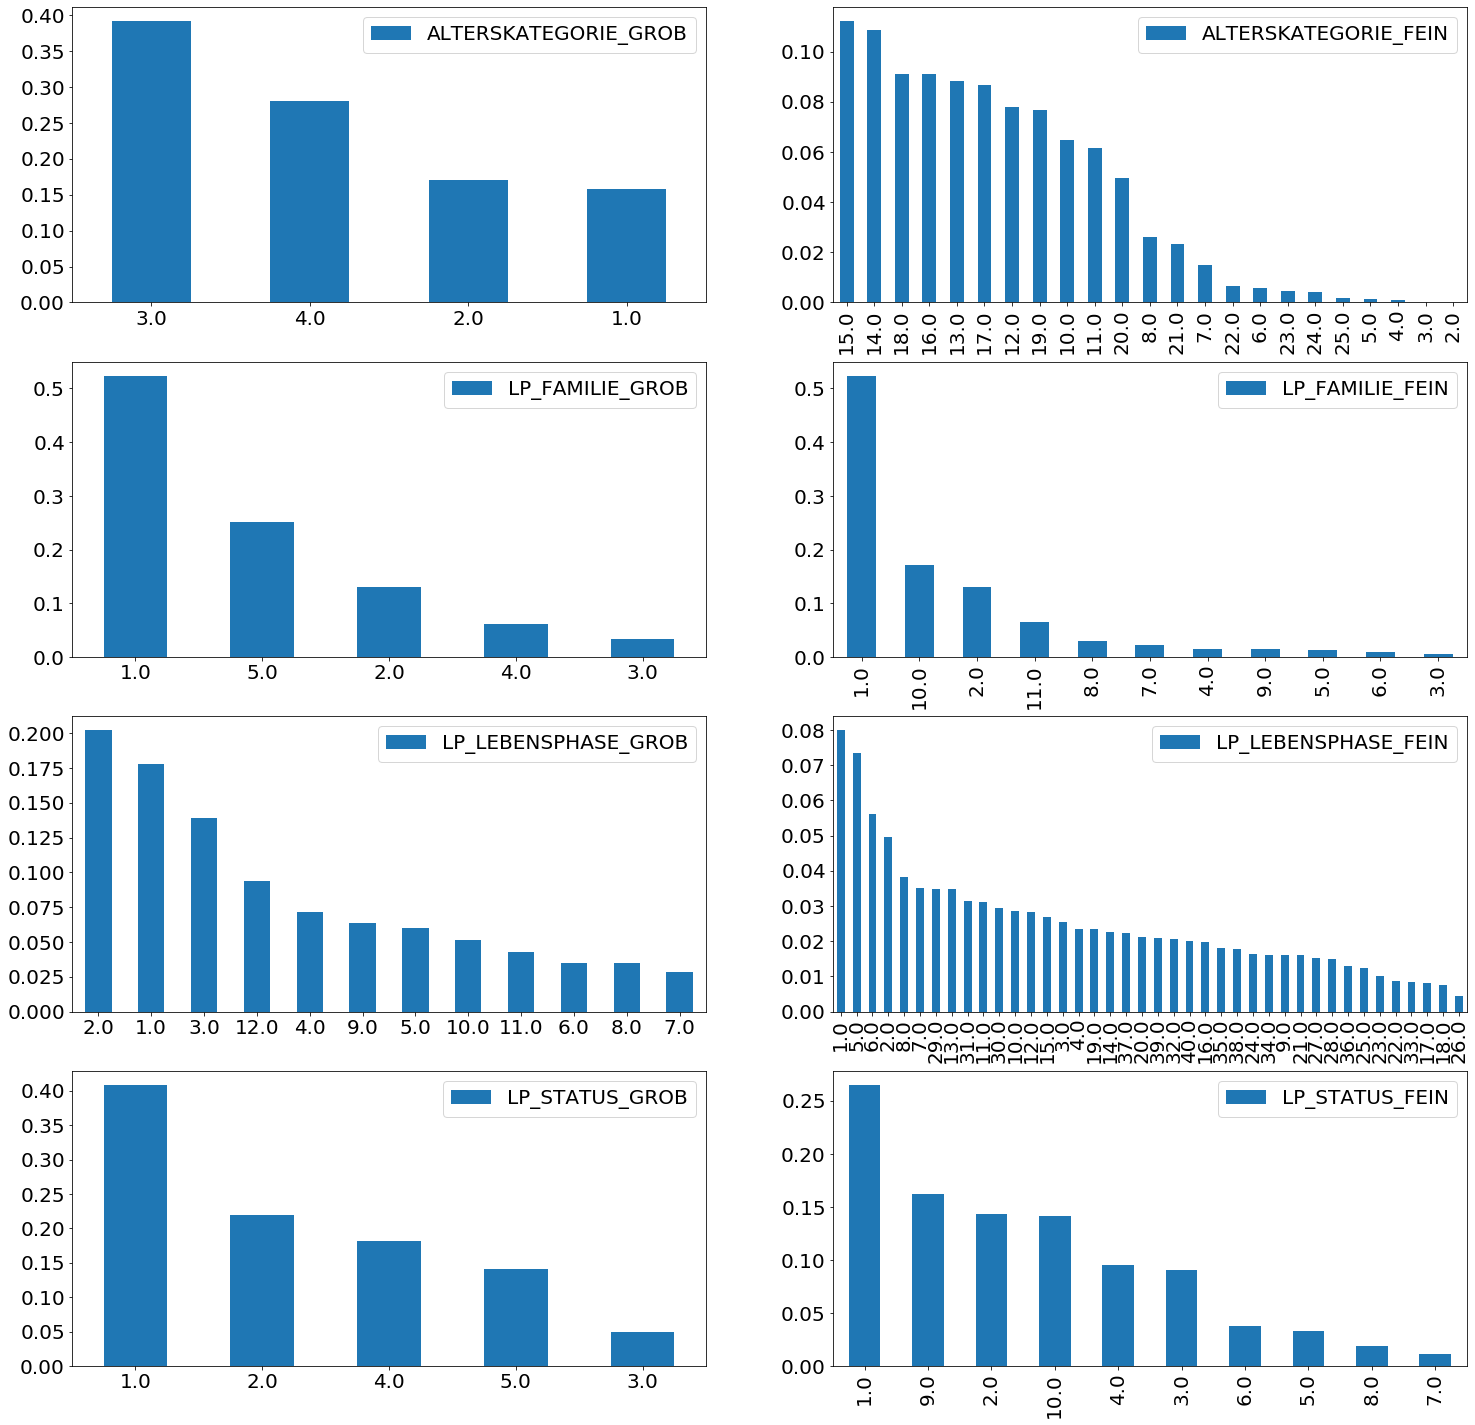

In [19]:
feats_fein =[x for x in eda_azdias.data.columns if x.endswith( '_FEIN')]
feats_grob = [x for x in eda_azdias.data.columns if x.endswith( '_GROB')]
feats_duplicate = [x for x in zip(pd.Series(feats_grob).sort_values(), pd.Series(feats_fein).sort_values())]
h.plot_2feats_comparison(eda_azdias.data, feats_duplicate)   

In [20]:
# CAMEO_DEU_2015 and CAMEO_DEUG_2015 are both describing the wealth and life stage topology but at different scales. I've decided to keep CAMEO_DEUG_2015 which describes the information at a rough scale and drop CAMEO_DEU_2015. Another reason for dropping this feature is that it contains over 40 categories.

In [21]:
feats_duplicated = ['ALTERSKATEGORIE_FEIN', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 'LP_STATUS_GROB']

In [22]:
eda_azdias.feat_info.loc[feats_duplicated,'action'] = h.action_dic[2]
eda_azdias.feat_info.loc[feats_duplicated,'is_drop'] = 1

eda_customers.feat_info.loc[feats_duplicated,'action'] = h.action_dic[2]
eda_customers.feat_info.loc[feats_duplicated,'is_drop'] = 1

In [23]:
eda_azdias.feat_info.loc[feats_duplicated]

,type,unknow,is_drop,action,n_nans,percent_of_nans,value_distinct,value_count,value_mean,value_std,value_min,value_max,value_Q1,value_Q3,value_IRQ
feat,,,,,,,,,,,,,,,
ALTERSKATEGORIE_FEIN,ordinal,"[-1,0,9]",1,drop: duplicated,22818,0.310,24,50809.0,14.897085,3.543599,2.0,25.0,12.0,18.0,6.0
LP_FAMILIE_FEIN,categorical,[0],1,drop: duplicated,2704,0.037,12,70923.0,3.937002,3.959381,1.0,11.0,1.0,9.0,8.0
LP_LEBENSPHASE_FEIN,mixed,[0],1,drop: duplicated,4360,0.059,41,69267.0,16.302987,12.292350,1.0,40.0,5.0,29.0,24.0
LP_STATUS_GROB,categorical,[0],1,drop: duplicated,320,0.004,6,73307.0,2.427763,1.508369,1.0,5.0,1.0,4.0,3.0


#### Step 4: Re-encodings features

a.  Re-encodings binary/categorical/mixed features

In [24]:
feats_encoding = [
                  'OST_WEST_KZ',
                  'CAMEO_DEUG_2015',
#                   'CAMEO_DEU_2015',
                  'CAMEO_INTL_2015',
#                   'EINGEFUEGT_AM',
#                   'D19_LETZTER_KAUF_BRANCHE',    
]

# h.check_features(eda_azdias, encoding)     
for x in feats_encoding:
     print(x, eda_azdias.data[x].unique())

OST_WEST_KZ ['W' 'O']
CAMEO_DEUG_2015 ['5' '2' 4.0 '6' '7' 6.0 9.0 '3' '9' 2.0 '4' 8.0 nan '8' 5.0 1.0 7.0 3.0
 '1']
CAMEO_INTL_2015 ['32' '31' '14' 23.0 '45' '54' 43.0 51.0 '25' '51' 14.0 '22' 52.0 '13'
 24.0 '24' '12' 41.0 44.0 '34' '33' nan 54.0 '23' '41' '43' 31.0 33.0 '52'
 13.0 22.0 55.0 '35' 25.0 15.0 34.0 12.0 35.0 '55' '15' '44' 45.0 32.0]


In [25]:
for x in feats_encoding:
    eda_azdias.re_encoding(x)
    eda_customers.re_encoding(x)        

b.  Re-encodings numeric features

In [26]:
eda_azdias.feat_info.loc[(eda_azdias.feat_info.type == 'numeric') & (eda_azdias.feat_info.is_drop == 0)]

,type,unknow,is_drop,action,n_nans,percent_of_nans,value_distinct,value_count,value_mean,value_std,value_min,value_max,value_Q1,value_Q3,value_IRQ
feat,,,,,,,,,,,,,,,
ANZ_HAUSHALTE_AKTIV,numeric,[],0,0,0,0.000,216,73627.0,8.149945,14.670269,0.0,445.0,2.0,9.0,7.0
ANZ_HH_TITEL,numeric,[],0,0,322,0.004,17,73305.0,0.037896,0.296049,0.0,15.0,0.0,0.0,0.0
ANZ_KINDER,numeric,[],0,0,0,0.000,9,73627.0,0.147609,0.494308,0.0,9.0,0.0,0.0,0.0
ANZ_PERSONEN,numeric,[],0,0,0,0.000,17,73627.0,1.745338,1.175088,0.0,37.0,1.0,2.0,1.0
ANZ_STATISTISCHE_HAUSHALTE,numeric,[],0,0,0,0.000,202,73627.0,7.422929,13.421582,0.0,366.0,1.0,9.0,8.0
ANZ_TITEL,numeric,[],0,0,0,0.000,3,73627.0,0.004034,0.066928,0.0,2.0,0.0,0.0,0.0
EINGEZOGENAM_HH_JAHR,numeric,[],0,0,0,0.000,33,73627.0,2003.403059,7.042655,1986.0,2018.0,1997.0,2009.0,12.0
GEBURTSJAHR,numeric,[0],0,0,28634,0.389,112,44993.0,1966.918298,17.825703,1905.0,2017.0,1954.0,1981.0,27.0
KBA13_ANZAHL_PKW,numeric,[],0,0,0,0.000,1248,73627.0,617.661863,336.302937,0.0,2300.0,384.0,774.0,390.0


In [27]:
numeric_feats = eda_azdias.feat_info.loc[(eda_azdias.feat_info.type == 'numeric') & (eda_azdias.feat_info.is_drop == 0)].index
numeric_feats = numeric_feats.drop(['EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR', 'MIN_GEBAEUDEJAHR'])
data = eda_azdias.data[numeric_feats]
# pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (20,12), diagonal = 'kde')

- ANZ_HAUSHALTE_AKTIV appears rather highly correlated with ANZ_STATISTISCHE_HAUSHALTE.  so I decide delete ANZ_STATISTISCHE_HAUSHALTE and keep ANZ_HAUSHALTE_AKTIV. 
- ANZ_HAUSHALTE_AKTIV and KBA13_ANZAHL_PKW appear to have a skewed distribution,  I will apply the natural logarithmic transformation to them

In [28]:
eda_azdias.feat_info.loc['ANZ_STATISTISCHE_HAUSHALTE' ,['is_drop', 'action']] = 1,  h.action_dic[2]
eda_customers.feat_info.loc['ANZ_STATISTISCHE_HAUSHALTE' ,['is_drop', 'action']]  = 1,  h.action_dic[2]

eda_azdias.data['ANZ_HAUSHALTE_AKTIV'] =  np.log(eda_azdias.data['ANZ_HAUSHALTE_AKTIV'] +2)
eda_azdias.data['KBA13_ANZAHL_PKW'] =  np.log(eda_azdias.data['KBA13_ANZAHL_PKW'])

eda_customers.data['ANZ_HAUSHALTE_AKTIV'] =  np.log(eda_customers.data['ANZ_HAUSHALTE_AKTIV'] +2)
eda_customers.data['KBA13_ANZAHL_PKW'] =  np.log(eda_customers.data['KBA13_ANZAHL_PKW'])

eda_azdias.feat_info.loc['ANZ_STATISTISCHE_HAUSHALTE','action'] =h.action_dic[4]
eda_customers.feat_info.loc['ANZ_STATISTISCHE_HAUSHALTE','action']  = h.action_dic[4]

In [29]:
# pd.plotting.scatter_matrix(eda_azdias.data[['ANZ_HAUSHALTE_AKTIV', 'KBA13_ANZAHL_PKW']] , alpha = 0.3, figsize = (20,12), diagonal = 'kde')

In [30]:
# Re-Collecting feature stats
eda_azdias.update_stats()
eda_customers.update_stats()

####  Step 5. Split Mixed Features

In [31]:
# mixed = eda_azdias.feat_info[ (eda_azdias.feat_info['type'] == 'mixed') & (eda_azdias.feat_info.is_drop == '0')]
mixed_feats = eda_azdias.feat_info[ (eda_azdias.feat_info.type == 'mixed') & (eda_azdias.feat_info.is_drop == 0)]
mixed_feats

,type,unknow,is_drop,action,n_nans,percent_of_nans,value_distinct,value_count,value_mean,value_std,value_min,value_max,value_Q1,value_Q3,value_IRQ
feat,,,,,,,,,,,,,,,
CAMEO_INTL_2015,mixed,"['-1','XX']",0,re-encoding: mapping,329,0.004,22,73298.0,35.635993,14.053103,12.0,55.0,24.0,51.0,27.0
LP_LEBENSPHASE_GROB,mixed,[0],0,0,4116,0.056,13,69511.0,4.950770,3.764575,1.0,12.0,2.0,9.0,7.0
PRAEGENDE_JUGENDJAHRE,mixed,"[-1,0]",0,0,2017,0.027,16,71610.0,9.236615,4.028728,1.0,15.0,6.0,14.0,8.0
EINGEFUEGT_AM,mixed,[],0,0,0,0.000,1819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# mixed_feats = ['CAMEO_INTL_2015', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'EINGEFUEGT_AM']
for x in mixed_feats.index:
    eda_azdias.split_mixed_feat(x)
    eda_customers.split_mixed_feat(x)           

In [33]:
feats_splited = ['CAMEO_INTL_2015_SPLIT_WEALTH', 'CAMEO_INTL_2015_SPLIT_LIFE_STAGE','LP_LEBENSPHASE_GROB_SPLIT_FAMILY','LP_LEBENSPHASE_GROB_SPLIT_AGE','LP_LEBENSPHASE_GROB_SPLIT_INCOME','PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE','PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT']
eda_azdias.data[feats_splited]

,CAMEO_INTL_2015_SPLIT_WEALTH,CAMEO_INTL_2015_SPLIT_LIFE_STAGE,LP_LEBENSPHASE_GROB_SPLIT_FAMILY,LP_LEBENSPHASE_GROB_SPLIT_AGE,LP_LEBENSPHASE_GROB_SPLIT_INCOME,PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE,PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT
93351,3.0,2.0,5.0,1.0,1.0,4.0,0.0
126224,3.0,1.0,0.0,0.0,0.0,5.0,0.0
657528,1.0,4.0,5.0,1.0,1.0,2.0,0.0
186660,2.0,3.0,0.0,NaN,1.0,3.0,0.0
789048,4.0,5.0,0.0,0.0,0.0,4.0,1.0
...,...,...,...,...,...,...,...
828694,1.0,4.0,0.0,0.0,0.0,5.0,0.0
853422,5.0,5.0,0.0,1.0,0.0,4.0,0.0
23990,4.0,3.0,NaN,NaN,NaN,5.0,0.0
391279,5.0,1.0,NaN,NaN,NaN,3.0,0.0


In [34]:
feats_splited_info = pd.DataFrame({
    'type': pd.Series('categorical', index = feats_splited),
    'unknow': pd.Series('[]', index = feats_splited)},
index = feats_splited)
                
feat_info_split = eda_azdias.build_feat_info(feats_splited_info)
eda_azdias.feat_info= pd.concat([eda_azdias.feat_info, feat_info_split], sort = False)
# eda_azdias.feat_info

feat_info_split = eda_customers.build_feat_info(feats_splited_info)
eda_customers.feat_info= pd.concat([eda_customers.feat_info, feat_info_split], sort = False)
# eda_customers.feat_info

In [35]:
eda_azdias.update_stats()
eda_customers.update_stats()

#### Step 6. Remove features with high distinct values

In [36]:
to_drop = eda_azdias.feat_info.loc[(eda_azdias.feat_info.is_drop == 0) & (eda_azdias.feat_info.value_distinct > 40)].index

eda_azdias.feat_info.loc[to_drop ,['is_drop', 'action']] = 1, h.action_dic[10]   
eda_azdias.data.drop(columns = to_drop, inplace =True)

to_drop = eda_customers.feat_info.loc[(eda_customers.feat_info.is_drop == 0) & (eda_customers.feat_info.value_distinct > 40)].index
eda_customers.feat_info.loc[to_drop,['is_drop', 'action']] = 1, h.action_dic[10]   
eda_customers.data.drop(columns = to_drop, inplace =True)

# eda_azdias.feat_info.loc['D19_LETZTER_KAUF_BRANCHE']
obj_feats = eda_azdias.data.select_dtypes(include=['object']).columns

eda_azdias.feat_info.loc[obj_feats ,['is_drop', 'action']] = 1, h.action_dic[3]   
eda_azdias.data.drop(columns = obj_feats, inplace =True)

obj_feats = eda_customers.data.select_dtypes(include=['object']).columns
eda_customers.feat_info.loc[obj_feats,['is_drop', 'action']] = 1, h.action_dic[3]   
eda_customers.data.drop(columns = obj_feats, inplace =True)

#### Step 7.  Remove outliers

In [37]:
outlier_feats = eda_azdias.feat_info[ eda_azdias.feat_info.is_drop == 0].index
eda_azdias.clean_outlier(outlier_feats)
eda_customers.clean_outlier(outlier_feats)

Cleaning outliers for AGER_TYP  ...
Cleaning outliers for ALTERSKATEGORIE_GROB  ...
Cleaning outliers for ALTER_HH  ...
Cleaning outliers for ANREDE_KZ  ...
Cleaning outliers for ANZ_HH_TITEL  ...
Cleaning outliers for ANZ_KINDER  ...
Cleaning outliers for ANZ_PERSONEN  ...
Cleaning outliers for ANZ_TITEL  ...
Cleaning outliers for ARBEIT  ...
Cleaning outliers for BALLRAUM  ...
Cleaning outliers for CAMEO_DEUG_2015  ...
Cleaning outliers for CJT_GESAMTTYP  ...
Cleaning outliers for D19_BUCH_CD  ...
Cleaning outliers for D19_GESAMT_ANZ_12  ...
Cleaning outliers for D19_GESAMT_ANZ_24  ...
Cleaning outliers for D19_GESAMT_DATUM  ...
Cleaning outliers for D19_GESAMT_OFFLINE_DATUM  ...
Cleaning outliers for D19_GESAMT_ONLINE_DATUM  ...
Cleaning outliers for D19_KONSUMTYP  ...
Cleaning outliers for D19_SONSTIGE  ...
Cleaning outliers for D19_SOZIALES  ...
Cleaning outliers for D19_VERSAND_ANZ_24  ...
Cleaning outliers for D19_VERSAND_DATUM  ...
Cleaning outliers for D19_VERSAND_OFFLINE_DATU

Cleaning outliers for KBA13_RENAULT  ...
Cleaning outliers for KBA13_SEG_GELAENDEWAGEN  ...
Cleaning outliers for KBA13_SEG_GROSSRAUMVANS  ...
Cleaning outliers for KBA13_SEG_KLEINST  ...
Cleaning outliers for KBA13_SEG_KLEINWAGEN  ...
Cleaning outliers for KBA13_SEG_KOMPAKTKLASSE  ...
Cleaning outliers for KBA13_SEG_MINIVANS  ...
Cleaning outliers for KBA13_SEG_MINIWAGEN  ...
Cleaning outliers for KBA13_SEG_MITTELKLASSE  ...
Cleaning outliers for KBA13_SEG_OBEREMITTELKLASSE  ...
Cleaning outliers for KBA13_SEG_OBERKLASSE  ...
Cleaning outliers for KBA13_SEG_SONSTIGE  ...
Cleaning outliers for KBA13_SEG_SPORTWAGEN  ...
Cleaning outliers for KBA13_SEG_UTILITIES  ...
Cleaning outliers for KBA13_SEG_VAN  ...
Cleaning outliers for KBA13_SEG_WOHNMOBILE  ...
Cleaning outliers for KBA13_SITZE_4  ...
Cleaning outliers for KBA13_SITZE_5  ...
Cleaning outliers for KBA13_SITZE_6  ...
Cleaning outliers for KBA13_TOYOTA  ...
Cleaning outliers for KBA13_VORB_0  ...
Cleaning outliers for KBA13_VORB_1

Cleaning outliers for KBA05_SEG6  ...
Cleaning outliers for KBA05_SEG7  ...
Cleaning outliers for KBA05_SEG8  ...
Cleaning outliers for KBA05_SEG9  ...
Cleaning outliers for KBA05_VORB0  ...
Cleaning outliers for KBA05_VORB1  ...
Cleaning outliers for KBA05_VORB2  ...
Cleaning outliers for KBA05_ZUL1  ...
Cleaning outliers for KBA05_ZUL2  ...
Cleaning outliers for KBA05_ZUL3  ...
Cleaning outliers for KBA05_ZUL4  ...
Cleaning outliers for KBA13_ALTERHALTER_30  ...
Cleaning outliers for KBA13_ALTERHALTER_45  ...
Cleaning outliers for KBA13_ALTERHALTER_60  ...
Cleaning outliers for KBA13_ALTERHALTER_61  ...
Cleaning outliers for KBA13_ANTG1  ...
Cleaning outliers for KBA13_ANTG2  ...
Cleaning outliers for KBA13_ANTG3  ...
Cleaning outliers for KBA13_ANTG4  ...
Cleaning outliers for KBA13_AUDI  ...
Cleaning outliers for KBA13_AUTOQUOTE  ...
Cleaning outliers for KBA13_BAUMAX  ...
Cleaning outliers for KBA13_BJ_1999  ...
Cleaning outliers for KBA13_BJ_2000  ...
Cleaning outliers for KBA13_

Cleaning outliers for LP_LEBENSPHASE_GROB_SPLIT_INCOME  ...
Cleaning outliers for PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE  ...
Cleaning outliers for PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT  ...


#### Step 8.  Feature Selection

##### a. Check for highly correlated features

In [38]:
feats = eda_azdias.feat_info.loc[eda_azdias.feat_info.is_drop == 0].index
corr_matrix_azdias = eda_azdias.data.loc[:, feats].dropna().corr().abs()
corr_matrix_azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,CAMEO_INTL_2015_SPLIT_WEALTH,CAMEO_INTL_2015_SPLIT_LIFE_STAGE,LP_LEBENSPHASE_GROB_SPLIT_FAMILY,LP_LEBENSPHASE_GROB_SPLIT_AGE,LP_LEBENSPHASE_GROB_SPLIT_INCOME,PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE,PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT
AGER_TYP,1.000000,0.268971,0.012386,0.151794,NaN,NaN,0.085832,NaN,0.052367,0.066838,...,0.141427,0.022573,0.004994,0.148756,0.049618,0.071164,NaN,0.096286,0.023381,NaN
ALTERSKATEGORIE_GROB,0.268971,1.000000,0.108320,0.077601,NaN,NaN,0.005226,NaN,0.023809,0.108600,...,0.136879,0.084269,0.025965,0.017079,0.079370,0.015030,NaN,0.043027,0.248873,NaN
ALTER_HH,0.012386,0.108320,1.000000,0.090519,NaN,NaN,0.649681,NaN,0.261088,0.131947,...,0.140835,0.318524,0.108509,0.321363,0.035214,0.639679,NaN,0.540211,0.395262,NaN
ANREDE_KZ,0.151794,0.077601,0.090519,1.000000,NaN,NaN,0.176405,NaN,0.002473,0.012938,...,0.050923,0.060091,0.007097,0.013845,0.073068,0.092716,NaN,0.100200,0.096331,NaN
ANZ_HH_TITEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# Upper triangle of correlations
upper_azdias = corr_matrix_azdias.where(np.triu(np.ones(corr_matrix_azdias.shape), k=1).astype(np.bool))
upper_azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,CAMEO_INTL_2015_SPLIT_WEALTH,CAMEO_INTL_2015_SPLIT_LIFE_STAGE,LP_LEBENSPHASE_GROB_SPLIT_FAMILY,LP_LEBENSPHASE_GROB_SPLIT_AGE,LP_LEBENSPHASE_GROB_SPLIT_INCOME,PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE,PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT
AGER_TYP,NaN,0.268971,0.012386,0.151794,NaN,NaN,0.085832,NaN,0.052367,0.066838,...,0.141427,0.022573,0.004994,0.148756,0.049618,0.071164,NaN,0.096286,0.023381,NaN
ALTERSKATEGORIE_GROB,NaN,NaN,0.108320,0.077601,NaN,NaN,0.005226,NaN,0.023809,0.108600,...,0.136879,0.084269,0.025965,0.017079,0.079370,0.015030,NaN,0.043027,0.248873,NaN
ALTER_HH,NaN,NaN,NaN,0.090519,NaN,NaN,0.649681,NaN,0.261088,0.131947,...,0.140835,0.318524,0.108509,0.321363,0.035214,0.639679,NaN,0.540211,0.395262,NaN
ANREDE_KZ,NaN,NaN,NaN,NaN,NaN,NaN,0.176405,NaN,0.002473,0.012938,...,0.050923,0.060091,0.007097,0.013845,0.073068,0.092716,NaN,0.100200,0.096331,NaN
ANZ_HH_TITEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Select columns with correlations above threshold
threshold = 0.85
to_drop_azdias = [column for column in upper_azdias.columns if any(upper_azdias[column] > threshold)]

print(f'{eda_azdias}:  There are {len(to_drop_azdias)} with correlations above {threshold}.')

Azdias:  There are 24 with correlations above 0.85.


In [43]:
feats = eda_customers.feat_info.loc[eda_customers.feat_info.is_drop == 0].index
corr_matrix_cus = eda_customers.data.loc[:, feats].dropna().corr().abs()

# Upper triangle of correlations
upper_cus = corr_matrix_cus.where(np.triu(np.ones(corr_matrix_cus.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop_cus = [column for column in upper_cus.columns if any(upper_cus[column] > threshold)]

print(f'{eda_customers}: There are {len(to_drop_cus)} with correlations above {threshold}.')

Customers: There are 19 with correlations above 0.85.


In [45]:
to_drop = set(to_drop_azdias).intersection(set(to_drop_cus))
print(f'There are {len(to_drop)} columns to be removed due to with a correlation bigger than {threshold} !')

eda_azdias.feat_info.loc[to_drop ,['is_drop', 'action']] = 1, h.action_dic[8]   
eda_customers.feat_info.loc[to_drop,['is_drop', 'action']] = 1, h.action_dic[8]   

eda_azdias.data.drop(columns = to_drop, inplace =True)
eda_customers.data.drop(columns = to_drop, inplace =True)

There are 16 columns to be removed due to with a correlation bigger than 0.85 !


In [47]:
# Save the droped  features into a file.
feats_todrop1 = eda_azdias.feat_info.drop(feats_splited)[eda_azdias.feat_info.is_drop == 1].index.tolist()
feats_todrop2 = eda_customers.feat_info.drop(feats_splited)[ eda_customers.feat_info.is_drop == 1].index.tolist()

feats_todrop = list(set(feats_todrop1).intersection(set(feats_todrop2)))

for c in feats_todrop:
    if c in eda_azdias.data.columns:
        eda_azdias.data.drop(columns = c, inplace = True)     
        
    if c in eda_customers.data.columns:
        eda_customers.data.drop(columns = c, inplace = True)             
    
pd.Series(feats_todrop).sort_values().to_csv('feats_dropped.csv', index=False)

####  Step  8:  Impute missing value

In [65]:
impMedian = Imputer(strategy='median')
impFreq = Imputer(strategy='most_frequent')

# eda_azdias.data_imputed = pd.DataFrame(imputer.fit_transform(eda_azdias.data))
# eda_customers.data_imputed = pd.DataFrame(imputer.fit_transform(eda_customers.data))
# other_feats = eda_azdias.data.columns.drop(numeric_feats)
# numeric_imputed = pd.DataFrame(impMedian.fit_transform(eda_azdias.data[numeric_feats]), columns = numeric_feats)
# other_imputed = pd.DataFrame(impFreq.fit_transform(eda_azdias.data[other_feats]), columns =other_feats )
# eda_azdias.data_imputed =  pd.concat([other_imputed, numeric_imputed], axis=0)
# eda_azdias.data_imputed

eda_azdias.data_imputed = pd.DataFrame(impMedian.fit_transform(eda_azdias.data),  columns=eda_azdias.data.columns).astype('float')
eda_customers.data_imputed = pd.DataFrame(impMedian.fit_transform(eda_customers.data),  columns=eda_customers.data.columns).astype('float')

####  Step  9:   Feature  Scaling

In [66]:
eda_azdias.data_scaled = pd.DataFrame(StandardScaler().fit_transform(eda_azdias.data_imputed) , 
                                         columns=eda_azdias.data.columns)
eda_customers.data_scaled = pd.DataFrame(StandardScaler().fit_transform(eda_customers.data_imputed) , 
                                         columns=eda_customers.data.columns)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Principal component analysis (PCA)

total explained_variance:  0.972192295073344
n_components:  200


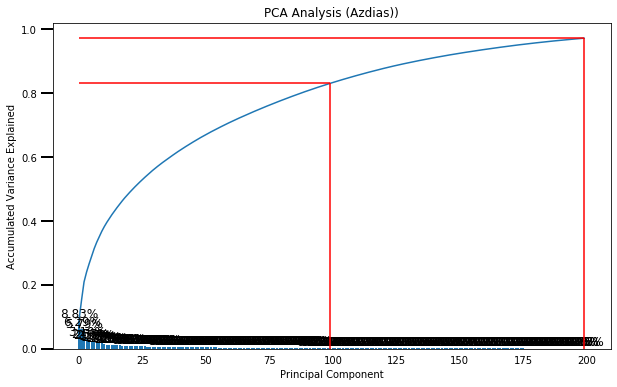

In [67]:
h.do_pca(eda_azdias, 200)

print(f'total explained_variance:  {eda_azdias.pca.explained_variance_ratio_.sum()}')
# print('explained_variance_ratio: ', pca.explained_variance_ratio_)
# print('explained_variance: ', pca.explained_variance_)
print('n_components: ', eda_azdias.pca.n_components_)

h.scree_plot(eda_azdias)

total explained_variance:  0.97535133662495
n_components:  200


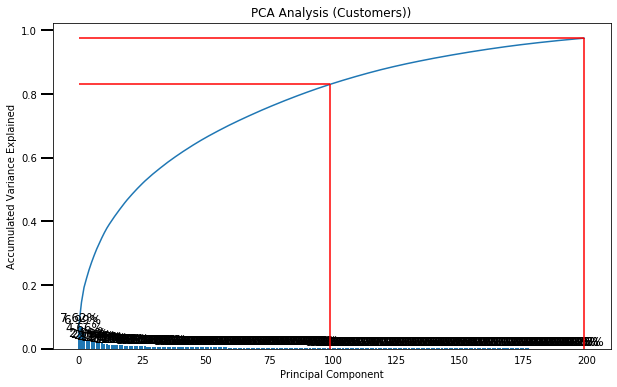

In [68]:
h.do_pca(eda_customers, 200)

print(f'total explained_variance:  {eda_customers.pca.explained_variance_ratio_.sum()}')
# print('explained_variance_ratio: ', pca.explained_variance_ratio_)
# print('explained_variance: ', pca.explained_variance_)
print('n_components: ', eda_customers.pca.n_components_)

h.scree_plot(eda_customers)

### Clustering with KMean

In [69]:
h.do_pca(eda_azdias, 100)
h.do_pca(eda_customers, 100)

Text(0.5, 1.0, 'SSE vs. K')

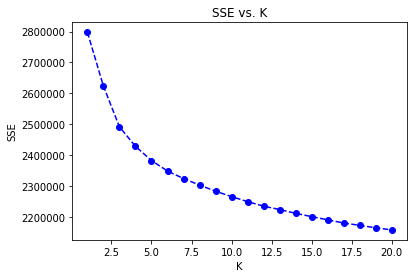

In [70]:
scores = []
centers = list(range(1,21))

for center in centers:
    _, score = h.get_kmeans_score(eda_customers.X_pca, center)
    scores.append(score)
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

####  Clustering Comparison  Azdias vs Customers 

In [71]:
model_c, score = h.get_kmeans_score(eda_customers.X_pca, 10)
print(score)
model_a, score = h.get_kmeans_score(eda_azdias.X_pca, 10)
print(score)

2265377.977
12632748.519


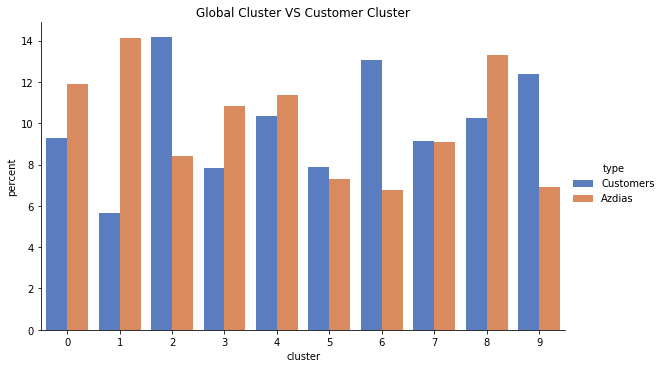

In [72]:
preds_c = model_c.predict(eda_customers.X_pca)
preds_a = model_a.predict(eda_azdias.X_pca)

counts_c, counts_a = h.plot_cluster_comparison(preds_c, preds_a)

In [73]:
comp_diff_s = (counts_c.percent - counts_a.percent).sort_values(ascending=False)
pd.DataFrame(
    {
        'cluster': comp_diff_s.index,
        'diff_pct': comp_diff_s.values
    }
)

,cluster,diff_pct
0,6,6.292623
1,2,5.735060
2,9,5.471319
3,5,0.604950
4,7,0.063612
5,4,-1.006721
6,0,-2.648098
7,3,-3.004419
8,8,-3.030370
9,1,-8.477956


The plot above represents the cluster distribution of the general population and the customers of the company. positive (cluster 2, 6, 9) is overrepresented and negative (cluster 9) is underrepresented. 

In [96]:
h.list_component(eda_customers,  2, 10)

[['PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE', 0.22900021064808274],
 ['CJT_TYP_1', 0.2163875926325212],
 ['CJT_TYP_2', 0.21476947330282917],
 ['FINANZ_SPARER', 0.21063919064106087],
 ['ALTER_HH', 0.16853517635406734],
 ['FINANZ_ANLEGER', 0.163707708617934],
 ['RT_UEBERGROESSE', 0.1619862176429608],
 ['ONLINE_AFFINITAET', 0.15327393908401718],
 ['SEMIO_PFLICHT', 0.15132821044639974],
 ['SEMIO_RAT', 0.14429468939394677],
 '^^^HEAD',
 'TAILvvv',
 ['D19_GESAMT_DATUM', -0.11026855799153018],
 ['SEMIO_LUST', -0.12913151379219717],
 ['W_KEIT_KIND_HH', -0.13983320522514558],
 ['ALTERSKATEGORIE_GROB', -0.1793509055830099],
 ['CJT_KATALOGNUTZER', -0.19395479856949233],
 ['FINANZ_VORSORGER', -0.20406719712422552],
 ['CJT_TYP_6', -0.21022469137762098],
 ['CJT_TYP_5', -0.21636014943941445],
 ['CJT_TYP_3', -0.2172363276872437],
 ['CJT_TYP_4', -0.22252589184421723]]

In [74]:
h.list_component(eda_customers,  6, 10)

[['KBA13_KW_61_120', 0.19012248405206197],
 ['KBA13_VORB_0', 0.17811423868625426],
 ['KBA13_KMH_210', 0.1763297586568316],
 ['KBA13_CCM_1401_2500', 0.15876707265173856],
 ['KBA13_SITZE_5', 0.14785774277052635],
 ['KBA13_KRSZUL_NEU', 0.13682315486533403],
 ['KBA13_BJ_2008', 0.11437120658032685],
 ['KBA13_CCM_2000', 0.10836716156379388],
 ['ARBEIT', 0.10578329610467044],
 ['KBA13_BJ_2009', 0.1055597820222159],
 '^^^HEAD',
 'TAILvvv',
 ['KBA13_CCM_1000', -0.12175439788067753],
 ['KBA13_KW_40', -0.12202546395084819],
 ['KBA13_SITZE_6', -0.12561311604965725],
 ['KBA13_CCM_0_1400', -0.14489856840883686],
 ['KBA13_VORB_2', -0.15051704311578723],
 ['KBA13_KW_0_60', -0.16202033164254953],
 ['KBA13_BJ_1999', -0.1640341008513472],
 ['KBA13_KMH_0_140', -0.16455075571488725],
 ['KBA13_KMH_140', -0.1688812192605738],
 ['KBA13_BJ_2000', -0.2039724892197046]]

In [101]:
h.list_component(eda_customers,  9, 10)

[['KBA13_ALTERHALTER_61', 0.15489115344905827],
 ['KBA13_HALTER_60', 0.13187472914494108],
 ['KBA05_KRSHERST2', 0.1283700015793809],
 ['KBA05_HERST2', 0.12762162459056928],
 ['KBA05_SEG3', 0.1266842062358764],
 ['KBA13_SEG_KOMPAKTKLASSE', 0.12347892830262536],
 ['KBA05_MOD3', 0.12016081856937594],
 ['KBA05_CCM2', 0.11987675416163873],
 ['KBA05_ALTER4', 0.11734754879659975],
 ['KBA13_KRSHERST_AUDI_VW', 0.1168434131641385],
 '^^^HEAD',
 'TAILvvv',
 ['KBA13_SEG_GROSSRAUMVANS', -0.1533469362906892],
 ['KBA13_HERST_EUROPA', -0.1555740338127215],
 ['KBA13_ALTERHALTER_30', -0.15732048995517034],
 ['KBA05_SEG9', -0.16442571711482154],
 ['KBA05_MOD8', -0.1698726123175442],
 ['KBA13_HALTER_30', -0.17203553082557707],
 ['KBA05_SEG10', -0.17506099802076402],
 ['KBA13_HALTER_35', -0.18904938435805535],
 ['KBA13_HALTER_40', -0.20090541395204034],
 ['KBA13_ALTERHALTER_45', -0.23352592212564044]]

In [103]:
h.list_component(eda_customers,  1, 10)

[['HH_EINKOMMEN_SCORE', 0.16220797954943714],
 ['CAMEO_DEUG_2015', 0.1437341569013039],
 ['KBA13_KW_0_60', 0.1247788378205329],
 ['KBA13_BAUMAX', 0.1212328323400148],
 ['KBA13_KMH_180', 0.11604058064294206],
 ['FINANZ_HAUSBAUER', 0.1071943236217585],
 ['ZABEOTYP', 0.1063651597582365],
 ['KBA13_ANTG3', 0.10489269306954603],
 ['KBA13_ANTG4', 0.10441634177603744],
 ['PLZ8_ANTG4', 0.10409584653965952],
 '^^^HEAD',
 'TAILvvv',
 ['KBA05_KW3', -0.10824196777411761],
 ['KBA05_AUTOQUOT', -0.11044399128250754],
 ['KBA05_GBZ', -0.11371281685938381],
 ['PRAEGENDE_JUGENDJAHRE_SPLIT_MOVEMENT', -0.11557012937112743],
 ['GREEN_AVANTGARDE', -0.1171301426655017],
 ['KBA13_ANTG1', -0.11762834156699489],
 ['KBA05_ANTG1', -0.12536982974354283],
 ['LP_STATUS_FEIN', -0.12966986015013407],
 ['MOBI_REGIO', -0.13073238835548312],
 ['FINANZ_MINIMALIST', -0.13616549456119725]]

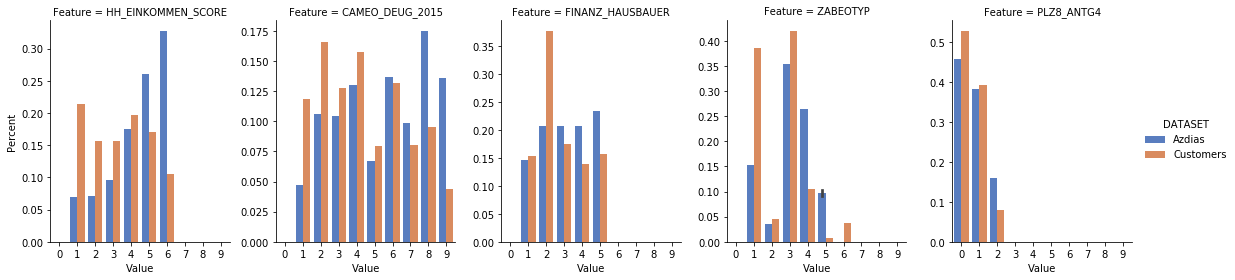

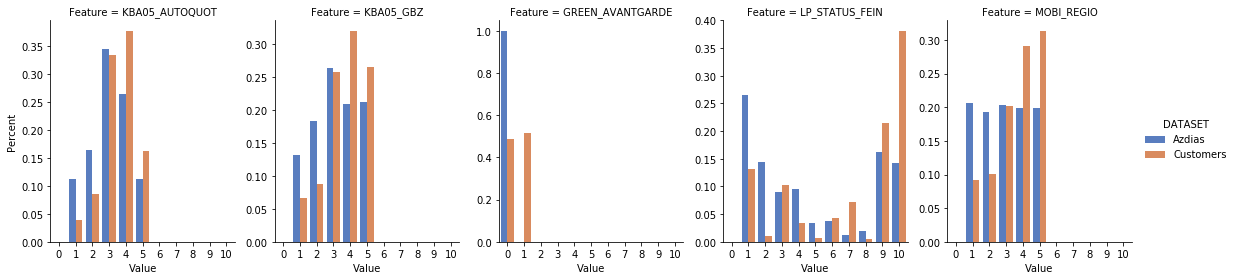

In [122]:
# Check  features of cluster 9
feats = ['HH_EINKOMMEN_SCORE', 'CAMEO_DEUG_2015', 'FINANZ_HAUSBAUER', 'ZABEOTYP', 'PLZ8_ANTG4', 
                'KBA05_AUTOQUOT', 'KBA05_GBZ','GREEN_AVANTGARDE', 'LP_STATUS_FEIN', 'MOBI_REGIO']
h.plot_feats_comparison(eda_azdias.data, eda_customers.data, feats, fig_height=4, fig_aspect=0.8)

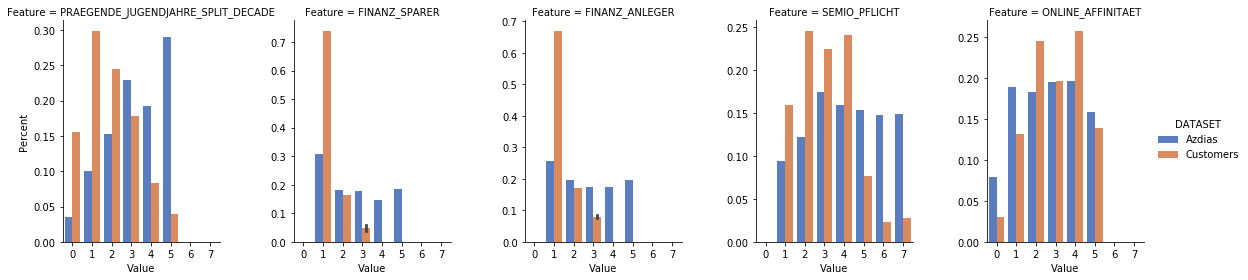

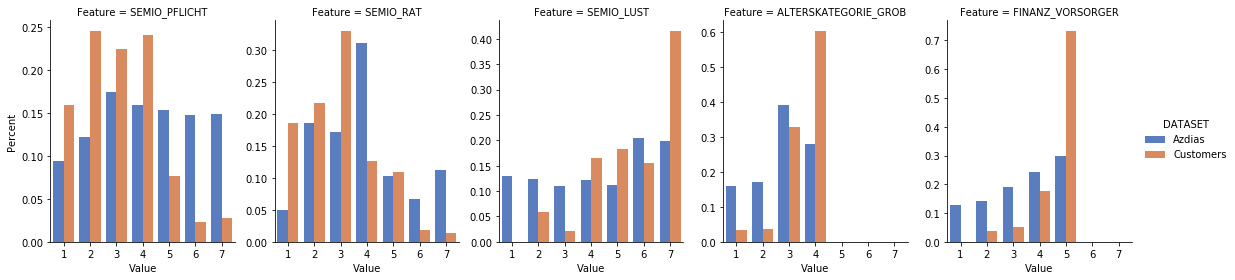

In [130]:
# Check  features of cluster 2
feats = ['PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE', 'FINANZ_SPARER', 'FINANZ_ANLEGER',
         'SEMIO_PFLICHT', 'ONLINE_AFFINITAET', 'SEMIO_PFLICHT', 'SEMIO_RAT',
        'SEMIO_LUST', 'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER']
h.plot_feats_comparison(eda_azdias.data, eda_customers.data, feats, fig_height=4, fig_aspect=0.8)

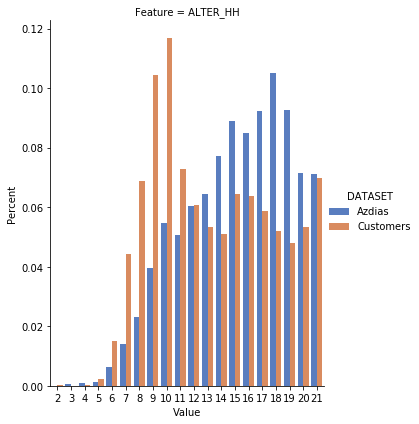

In [129]:
h.plot_feats_comparison(eda_azdias.data, eda_customers.data,['ALTER_HH'] , fig_height=6, fig_aspect=0.8)

So, people that use mail-order company are wealthy(#9:HH_EINKOMMEN_SCORE,  ) , 50–70 years old (#9: PRAEGENDE_JUGENDJAHRE_SPLIT_DECADE) , money savers and investors with high probability (#9: FINANZ_SPARER, #2: FINANZ_ANLEGER). They are high earners (#9: LP_STATUS_FEIN). These people are with low movement pattern (MOBI_REGIO=4.2). These people are also religious and traditional-minded (SEMIO feature).

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Step 1: Load the data

In [77]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_pickle ('..//data//mailout_train.p')    
mailout_train.shape

# read in feature info file
feat_info = pd.read_csv('./feats_info.csv', sep=';', names=['feat', 'type', 'unknow'])
feat_info.set_index('feat', inplace =True)

### Step 2: Preparing and splitting the data

In [78]:
positive_cnts = mailout_train[mailout_train['RESPONSE'] == 1].shape[0]
total_cnts = mailout_train.shape[0]
 
print(f'The train set contains only {positive_cnts / total_cnts *100 :1.2f}% customers with positive response')

The train set contains only 1.24% customers with positive response


(array([113.,   0.,   0.,   0.,   0.,  16., 229.,   2.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          3.]),
 array([0.        , 0.0293837 , 0.05876739, 0.08815109, 0.11753478,
        0.14691848, 0.17630218, 0.20568587, 0.23506957, 0.26445327,
        0.29383696, 0.32322066, 0.35260435, 0.38198805, 0.41137175,
        0.44075544, 0.47013914, 0.49952283, 0.52890653, 0.55829023,
        0.58767392, 0.61705762, 0.64644131, 0.67582501, 0.70520871,
        0.7345924 , 0.7639761 , 0.7933598 , 0.82274349, 0.85212719,
        0.88151088, 0.91089458, 0.94027828, 0.96966197, 0.99904567]),
 <a list of 34 Patch objects>)

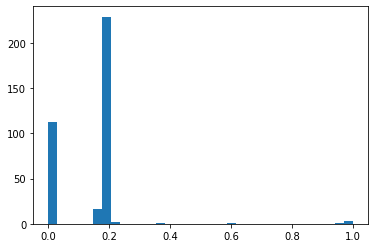

In [79]:
# extract RESPONSE column
response = mailout_train['RESPONSE']

# drop RESPONSE column
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

# find features to drop because of many missing values
missing_per_column = mailout_train.isnull().mean()

plt.hist(missing_per_column, bins=34)

In [80]:
# read in feature info file
# feat_info = pd.read_csv('./feats_info.csv', sep=';', names=['feat', 'type', 'unknown'])
# feat_info.set_index('feat', inplace =True)

eda_mailout_train = eda.EDA(mailout_train, feat_info, label = 'mailout_train')

#  Data Cleaning
eda_mailout_train.data_pipeline()

Step 1: Delete undefined, multiple missing values and duplicate features ...
Before cleaning, Number of columns is 366 in mailout_train 
After cleaning, Number of columns is 282 in mailout_train 
Step 2: Convert missing and unknow values ...
Number of missing values in mailout_train:
Before converstion is 1834924
Ater converstion IS 2158781
Increase in missing values: 17.65 % 
Step 3: Delete the rows with more NaN values ...
Before cleaning, Number of rows is 282 in mailout_train 
After cleaning, Number of columns is 282 in mailout_train 
  8380 lines deleted!
Step 4: Re-encoding features...
   Re-encoding: OST_WEST_KZ ...
   Re-encoding: CAMEO_DEUG_2015 ...
   Re-encoding: CAMEO_INTL_2015 ...
Step 5: Split mixed features ...
   Spliting: CAMEO_INTL_2015 ...
   Spliting: LP_LEBENSPHASE_GROB ...
   Spliting: PRAEGENDE_JUGENDJAHRE ...
   Spliting: EINGEFUEGT_AM ...
Step 6: Handling outliers ...
Cleaning outliers for AGER_TYP  ...
Cleaning outliers for ALTERSKATEGORIE_GROB  ...
Cleaning o

Cleaning outliers for KBA13_KW_120  ...
Cleaning outliers for KBA13_KW_121  ...
Cleaning outliers for KBA13_KW_30  ...
Cleaning outliers for KBA13_KW_40  ...
Cleaning outliers for KBA13_KW_50  ...
Cleaning outliers for KBA13_KW_60  ...
Cleaning outliers for KBA13_KW_61_120  ...
Cleaning outliers for KBA13_KW_70  ...
Cleaning outliers for KBA13_KW_80  ...
Cleaning outliers for KBA13_KW_90  ...
Cleaning outliers for KBA13_MAZDA  ...
Cleaning outliers for KBA13_MERCEDES  ...
Cleaning outliers for KBA13_MOTOR  ...
Cleaning outliers for KBA13_NISSAN  ...
Cleaning outliers for KBA13_OPEL  ...
Cleaning outliers for KBA13_PEUGEOT  ...
Cleaning outliers for KBA13_RENAULT  ...
Cleaning outliers for KBA13_SEG_GELAENDEWAGEN  ...
Cleaning outliers for KBA13_SEG_GROSSRAUMVANS  ...
Cleaning outliers for KBA13_SEG_KLEINST  ...
Cleaning outliers for KBA13_SEG_KLEINWAGEN  ...
Cleaning outliers for KBA13_SEG_KOMPAKTKLASSE  ...
Cleaning outliers for KBA13_SEG_MINIVANS  ...
Cleaning outliers for KBA13_SEG_

In [81]:
response = response.loc[mailout_train.index]
response.shape

(34582,)

### Preparing and splitting the data

In [82]:
# We split the dataset into 2/3 training and 1/3 testing sets.
train_data, test_data, train_targets, test_targets = train_test_split(
    eda_mailout_train.data_scaled, 
    response, 
    test_size=0.33, 
    shuffle=True,
    random_state=h.RANDOM_STATE)

### Step 4. model evaluation

In [83]:
lrm = LogisticRegression(random_state=h.RANDOM_STATE)
bagm = BaggingClassifier()
lgbm = lgb.LGBMClassifier(random_state=h.RANDOM_STATE,application='binary')

model_dict = {
    'logistic regression': lrm,    
    'bagging': bagm,
    'lgbmclassifier': lgbm,
}

h.build_roc_auc(model_dict, {},eda_mailout_train.data_scaled, response)    

Model: logistic regression,  Best ROC AUC score:  0.7263887062284418
Model: bagging,  Best ROC AUC score:  0.5854895922858702
Model: lgbmclassifier,  Best ROC AUC score:  0.7361686739031477


The LGBM classifier got a slightly better score so I'll use it down below to train and tuning for the kaggle competition. 

### Step 5. LGB Train and Hyperparameter Tuning

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:06<00:00,  1.87s/trial, best loss: -0.7624883167299917]
Best ROC -0.762 params {'colsample_bytree': 0.688777246993937, 'feature_fraction': 0.47993852778005724, 'learning_rate': 7.315459393770224e-05, 'max_bin': 53.0, 'min_data_in_leaf': 1300.0, 'min_sum_hessian_in_leaf': 0.0014525746701834453, 'num_leaves': 5.0, 'reg_alpha': 0.7239239809481653, 'reg_lambda': 0.3886635234260231}


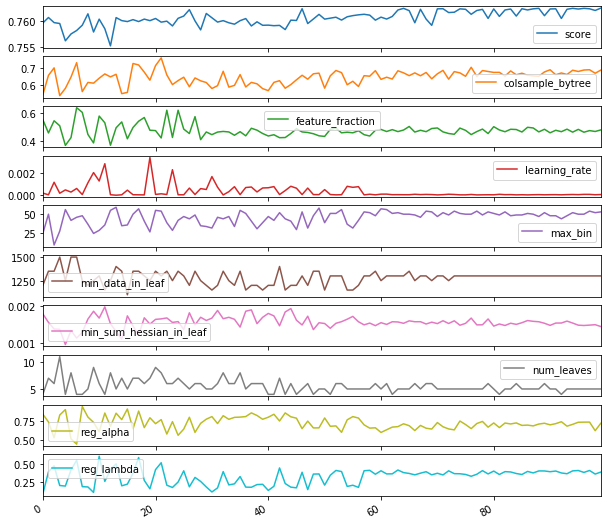

In [84]:
def_params={
        'learning_rate':  {'hpf' :  hp.loguniform('learning_rate', np.log(0.00001), np.log(0.0075)),'dtype' : 'float'},           
        'num_leaves' :    {'hpf' : hp.quniform('num_leaves', 3, 15, 1),'dtype' : 'int'},     
        'min_data_in_leaf' : {'hpf' : hp.quniform('min_data_in_leaf', 1000, 1500, 50),'dtype' : 'int'},     
        'min_sum_hessian_in_leaf':  {'hpf' : hp.uniform('min_sum_hessian_in_leaf', 0.0005, 0.002),'dtype' : 'float'},               
        'colsample_bytree': {'hpf': hp.uniform('colsample_bytree', 0.5, 0.9),'dtype' : 'float'},        
        'reg_alpha': {'hpf': hp.uniform('reg_alpha', 0.3, 1.0),'dtype' : 'float'}, 
        'reg_lambda': {'hpf': hp.uniform('reg_lambda', 0, 0.6),'dtype' : 'float'}, 
        'max_bin' :    {'hpf' : hp.quniform('max_bin', 10, 80, 1),'dtype' : 'int'},    
        'feature_fraction': {'hpf': hp.uniform('feature_fraction', 0.3, 0.7),'dtype' : 'float'},    
}

n_iter = 100
cv = 10

best, trials, objective = t.search_hyperparameter(def_params, n_iter, cv ,train_data, train_targets)

model = t.build_model(best, def_params)

model.fit(train_data,train_targets)

t.evaluate_model(model, objective, best, test_data, test_targets)

sa_results_df = t.plot_result(trials.trials)

### Step 6. Top 15 most important features of the model

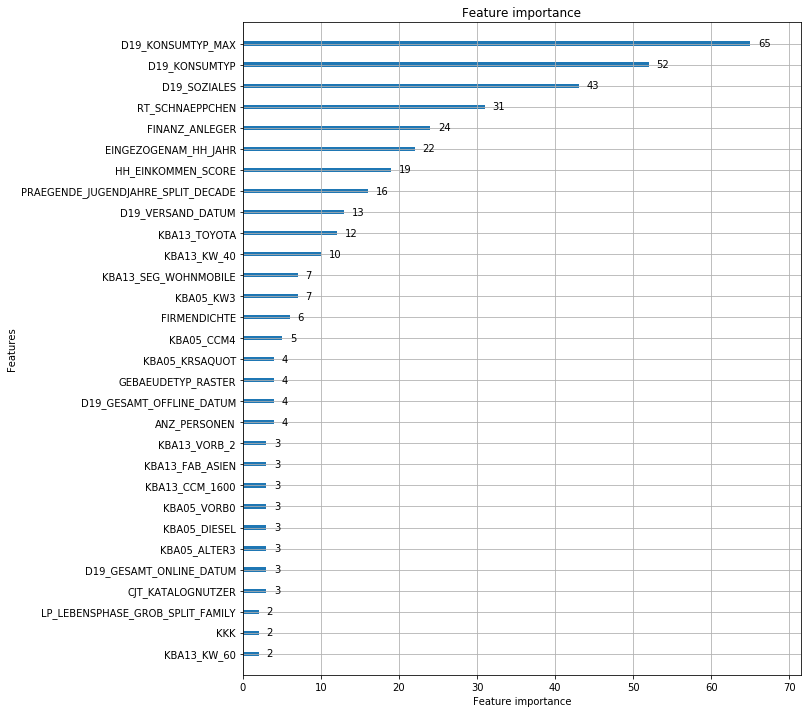

In [85]:
lgb.plot_importance(model, max_num_features = 30, figsize=(10,12))

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [86]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test = pd.read_pickle ('..//data//mailout_test.p')    
mailout_test.shape

(42833, 366)

In [87]:
eda_mailout_test = eda.EDA(mailout_test, feat_info, label = 'mailout_test')

In [88]:
LNR = mailout_test.LNR.copy()
LNR.shape

(42833,)

In [89]:
eda_mailout_test.data_pipeline(clean_rows = False)

Step 1: Delete undefined, multiple missing values and duplicate features ...
Before cleaning, Number of columns is 366 in mailout_test 
After cleaning, Number of columns is 282 in mailout_test 
Step 2: Convert missing and unknow values ...
Number of missing values in mailout_test:
Before converstion is 1807839
Ater converstion IS 2128457
Increase in missing values: 17.73 % 
Step 4: Re-encoding features...
   Re-encoding: OST_WEST_KZ ...
   Re-encoding: CAMEO_DEUG_2015 ...
   Re-encoding: CAMEO_INTL_2015 ...
Step 5: Split mixed features ...
   Spliting: CAMEO_INTL_2015 ...
   Spliting: LP_LEBENSPHASE_GROB ...
   Spliting: PRAEGENDE_JUGENDJAHRE ...
   Spliting: EINGEFUEGT_AM ...
Step 6: Handling outliers ...
Cleaning outliers for AGER_TYP  ...
Cleaning outliers for ALTERSKATEGORIE_GROB  ...
Cleaning outliers for ALTER_HH  ...
Cleaning outliers for ANREDE_KZ  ...
Cleaning outliers for ANZ_HH_TITEL  ...
Cleaning outliers for ANZ_KINDER  ...
Cleaning outliers for ANZ_PERSONEN  ...
Cleaning 

Cleaning outliers for KBA13_KW_60  ...
Cleaning outliers for KBA13_KW_61_120  ...
Cleaning outliers for KBA13_KW_70  ...
Cleaning outliers for KBA13_KW_80  ...
Cleaning outliers for KBA13_KW_90  ...
Cleaning outliers for KBA13_MAZDA  ...
Cleaning outliers for KBA13_MERCEDES  ...
Cleaning outliers for KBA13_MOTOR  ...
Cleaning outliers for KBA13_NISSAN  ...
Cleaning outliers for KBA13_OPEL  ...
Cleaning outliers for KBA13_PEUGEOT  ...
Cleaning outliers for KBA13_RENAULT  ...
Cleaning outliers for KBA13_SEG_GELAENDEWAGEN  ...
Cleaning outliers for KBA13_SEG_GROSSRAUMVANS  ...
Cleaning outliers for KBA13_SEG_KLEINST  ...
Cleaning outliers for KBA13_SEG_KLEINWAGEN  ...
Cleaning outliers for KBA13_SEG_KOMPAKTKLASSE  ...
Cleaning outliers for KBA13_SEG_MINIVANS  ...
Cleaning outliers for KBA13_SEG_MINIWAGEN  ...
Cleaning outliers for KBA13_SEG_MITTELKLASSE  ...
Cleaning outliers for KBA13_SEG_OBEREMITTELKLASSE  ...
Cleaning outliers for KBA13_SEG_OBERKLASSE  ...
Cleaning outliers for KBA13_S

In [90]:
# fit and predict
preds_test = model.predict_proba(eda_mailout_test.data_scaled)[:,1]
preds_test

array([0.50076214, 0.50032855, 0.49836227, ..., 0.5000906 , 0.49857593,
       0.49880885])

In [91]:
# create submission file
preds_test = pd.concat([LNR, pd.Series(preds_test)], axis = 1)
preds_test.rename(columns={0:'RESPONSE'}, inplace= True)
preds_test.to_csv('MAILOUT_TEST.csv') 